In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Statistical Tests
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind, kstest

# Model Interpretation
try:
    import shap
except:
    print("SHAP not installed. Install with: pip install shap")

# Model Persistence
import joblib
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/graphs', exist_ok=True)
os.makedirs('outputs/datasets', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)
os.makedirs('outputs/predictions', exist_ok=True)

In [2]:
print("="*80)
print("STEP 1: DATA LOADING")
print("="*80)

# Load balanced dataset for training
df_original = pd.read_csv('/kaggle/input/dsc-project-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

print(f"✓ Dataset loaded successfully")
print(f"  Shape: {df_original.shape}")
print(f"  Features: {df_original.shape[1]}")
print(f"  Samples: {df_original.shape[0]}")

STEP 1: DATA LOADING
✓ Dataset loaded successfully
  Shape: (70692, 22)
  Features: 22
  Samples: 70692



STEP 2: EXPLORATORY DATA ANALYSIS

Dataset Info:
  Columns: ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
  Missing Values: 0
  Duplicates: 1635

Target Distribution:
Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64

Class Balance:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

✓ Descriptive statistics calculated


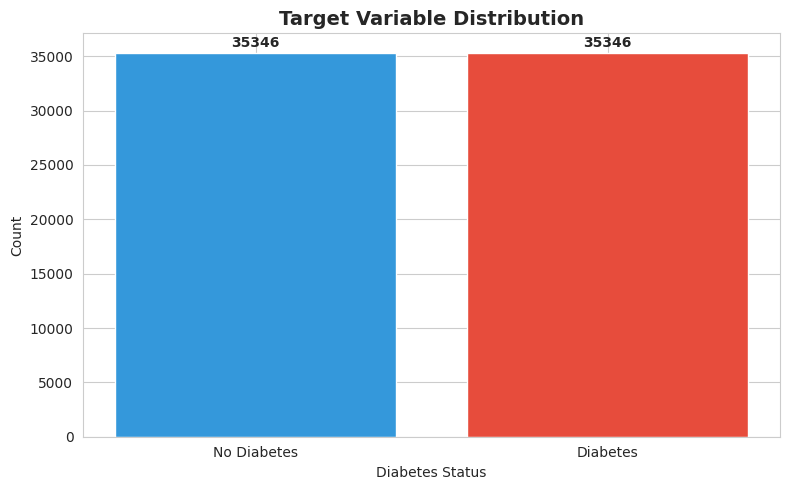

✓ Graph saved: 01_target_distribution.png


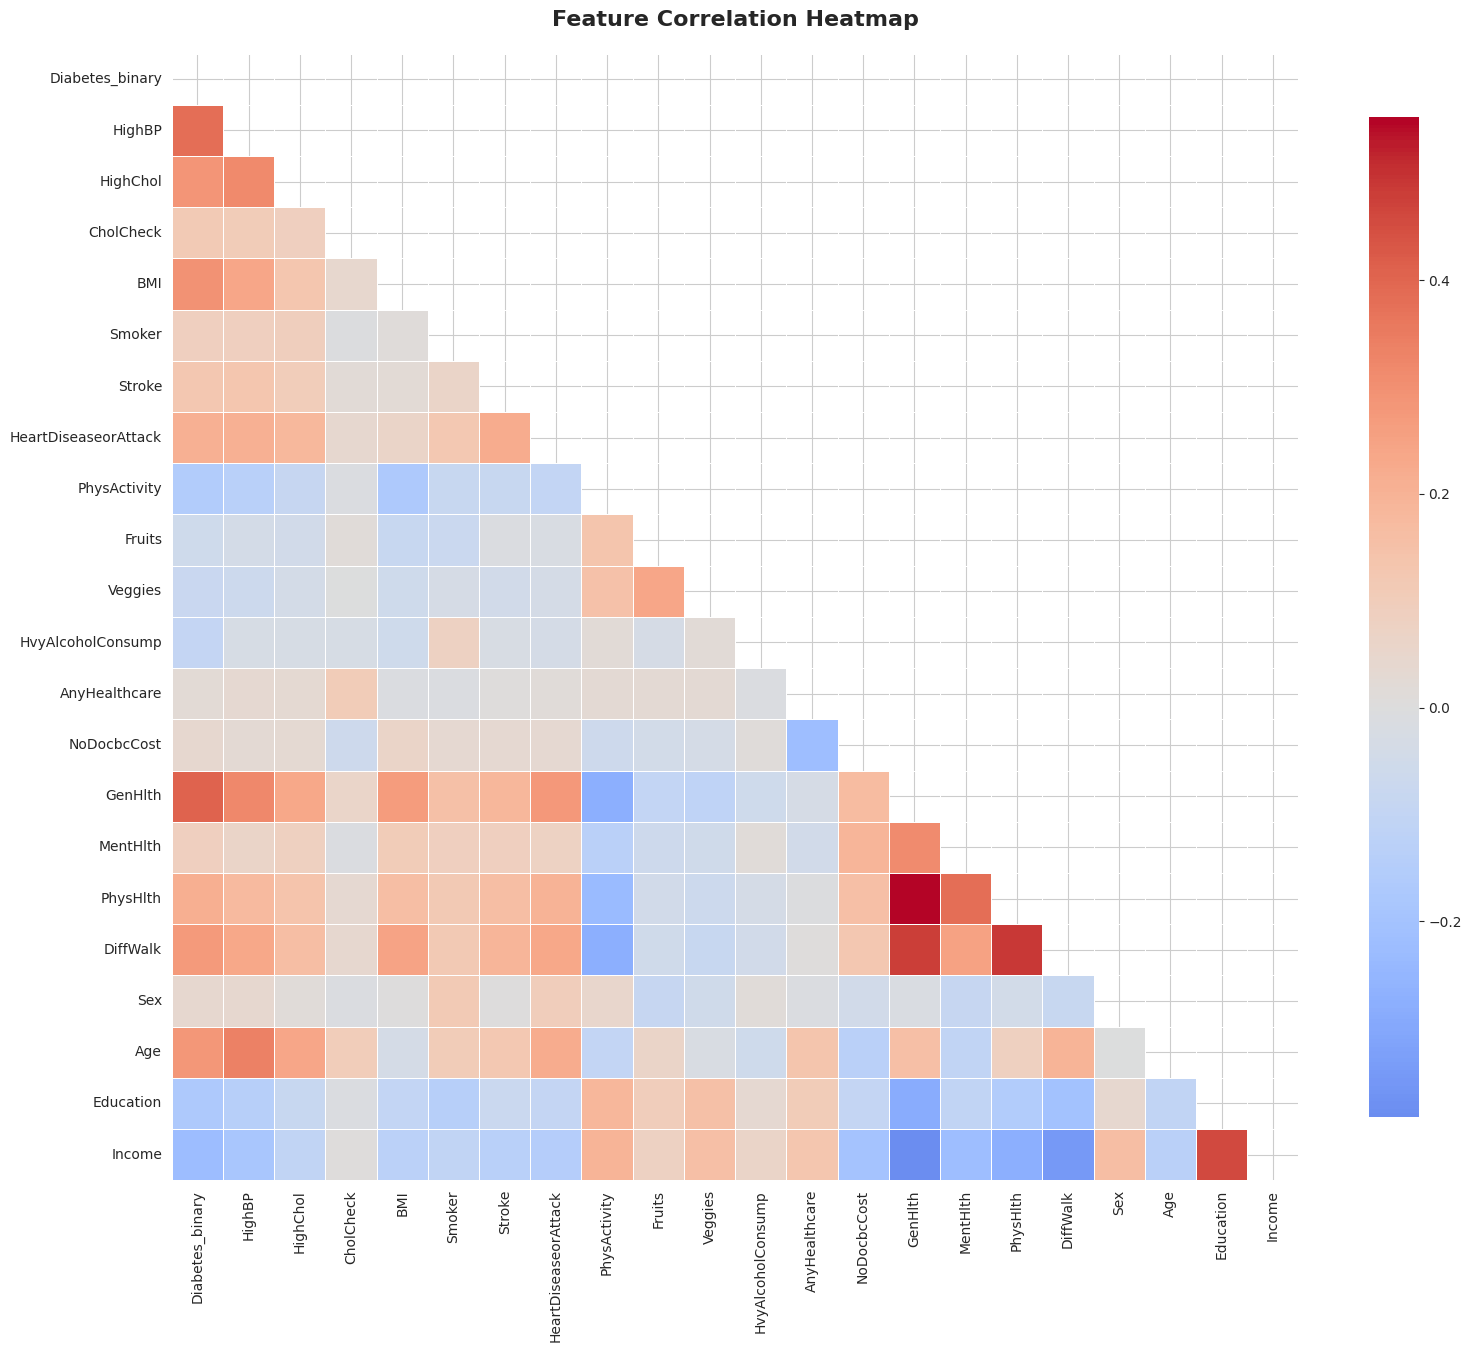

✓ Graph saved: 02_correlation_heatmap.png

Top 5 Features Correlated with Diabetes:
  1. GenHlth: 0.4076
  2. HighBP: 0.3815
  3. BMI: 0.2934
  4. HighChol: 0.2892
  5. Age: 0.2787


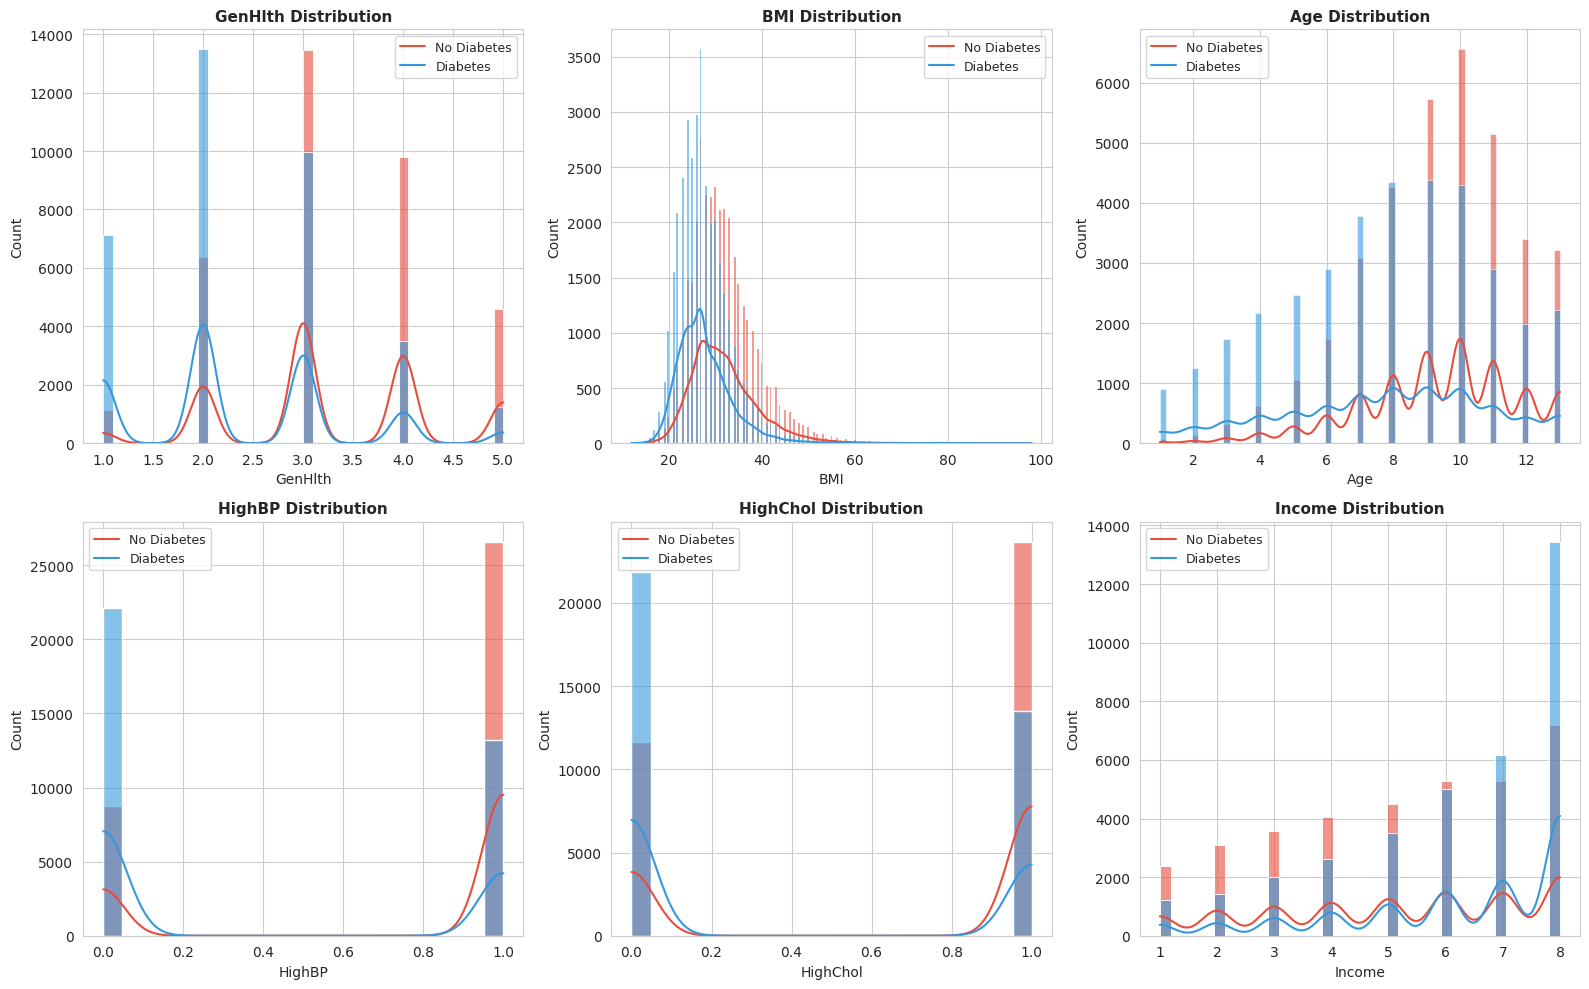

✓ Graph saved: 03_feature_distributions.png


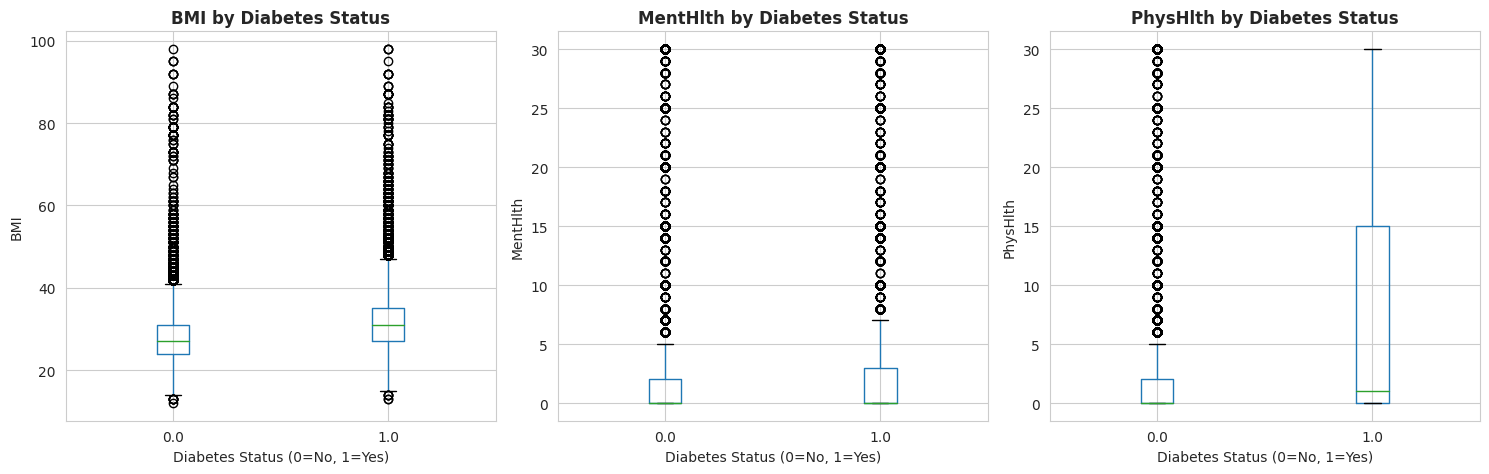

✓ Graph saved: 04_boxplots.png


In [7]:
print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*80)

df = df_original.copy()

# Basic information
print("\nDataset Info:")
print(f"  Columns: {df.columns.tolist()}")
print(f"  Missing Values: {df.isnull().sum().sum()}")
print(f"  Duplicates: {df.duplicated().sum()}")

# Target distribution
print(f"\nTarget Distribution:")
print(df['Diabetes_binary'].value_counts())
print(f"\nClass Balance:")
print(df['Diabetes_binary'].value_counts(normalize=True))

# Descriptive statistics
desc_stats = df.describe()
print("\n✓ Descriptive statistics calculated")

# GRAPH 1: Target Distribution
plt.figure(figsize=(8, 5))
target_counts = df['Diabetes_binary'].value_counts()
plt.bar(['No Diabetes', 'Diabetes'], target_counts.values, color=['#3498db', '#e74c3c'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/graphs/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 01_target_distribution.png")

# GRAPH 2: Correlation Heatmap
plt.figure(figsize=(16, 14))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/graphs/02_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 02_correlation_heatmap.png")

# Top correlations with target
target_corr = correlation_matrix['Diabetes_binary'].sort_values(ascending=False)
print("\nTop 5 Features Correlated with Diabetes:")
for i, (feature, corr) in enumerate(target_corr[1:6].items(), 1):
    print(f"  {i}. {feature}: {corr:.4f}")

# GRAPH 3: Feature Distributions
key_features = ['GenHlth', 'BMI', 'Age', 'HighBP', 'HighChol', 'Income']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    sns.histplot(data=df, x=feature, hue='Diabetes_binary', 
                 kde=True, ax=axes[idx], palette=['#3498db', '#e74c3c'], alpha=0.6)
    axes[idx].set_title(f'{feature} Distribution', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].legend(['No Diabetes', 'Diabetes'], fontsize=9)

plt.tight_layout()
plt.savefig('outputs/graphs/03_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 03_feature_distributions.png")

# GRAPH 4: Boxplots for Continuous Features
continuous_features = ['BMI', 'MentHlth', 'PhysHlth']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(continuous_features):
    df.boxplot(column=feature, by='Diabetes_binary', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Diabetes Status', fontweight='bold')
    axes[idx].set_xlabel('Diabetes Status (0=No, 1=Yes)')
    axes[idx].set_ylabel(feature)

plt.suptitle('')
plt.tight_layout()
plt.savefig('outputs/graphs/04_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 04_boxplots.png")

In [8]:
print("\n" + "="*80)
print("STEP 3: FEATURE ENGINEERING")
print("="*80)

def engineer_features(dataframe):
    """Apply feature engineering transformations"""
    df_engineered = dataframe.copy()
    
    # Composite health score
    df_engineered['HealthScore'] = (df_engineered['GenHlth'] + 
                                     df_engineered['PhysHlth'] + 
                                     df_engineered['MentHlth']) / 3
    
    # Risk factor count
    risk_factors = ['HighBP', 'HighChol', 'Smoker', 'HeartDiseaseorAttack', 'Stroke']
    df_engineered['RiskFactorCount'] = df_engineered[risk_factors].sum(axis=1)
    
    return df_engineered

# Apply feature engineering
df = engineer_features(df)

print("✓ Feature engineering completed")
print(f"  New features created: HealthScore, RiskFactorCount")
print(f"  Total features: {df.shape[1] - 1}")  # Excluding target


STEP 3: FEATURE ENGINEERING
✓ Feature engineering completed
  New features created: HealthScore, RiskFactorCount
  Total features: 23


In [9]:
print("\n" + "="*80)
print("STEP 4: DATA PREPROCESSING")
print("="*80)

# Check for missing values
print(f"Missing values: {df.isnull().sum().sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates} duplicate rows")

# Outlier detection and handling (for BMI)
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df['BMI'] < lower_bound) | (df['BMI'] > upper_bound)]
print(f"\nOutliers detected in BMI: {len(outliers)}")
print(f"  Lower bound: {lower_bound:.2f}")
print(f"  Upper bound: {upper_bound:.2f}")

# Cap outliers instead of removing
df['BMI'] = df['BMI'].clip(lower=lower_bound, upper=upper_bound)
print("✓ Outliers capped")

# Save processed dataset
processed_file = 'outputs/datasets/processed_dataset.csv'
df.to_csv(processed_file, index=False)
print(f"\n✓ Processed dataset saved: {processed_file}")
print(f"  Shape: {df.shape}")


STEP 4: DATA PREPROCESSING
Missing values: 0
Duplicate rows: 1635
✓ Removed 1635 duplicate rows

Outliers detected in BMI: 358
  Lower bound: 1.00
  Upper bound: 57.00
✓ Outliers capped

✓ Processed dataset saved: outputs/datasets/processed_dataset.csv
  Shape: (69057, 24)



STEP 5: TRAIN-TEST SPLIT
✓ Data split completed (80-20)
  Training samples: 55245
  Testing samples: 13812
  Features: 23

✓ Train dataset saved: outputs/datasets/train_dataset.csv
✓ Test dataset saved: outputs/datasets/test_dataset.csv
✓ Feature scaling completed (StandardScaler)


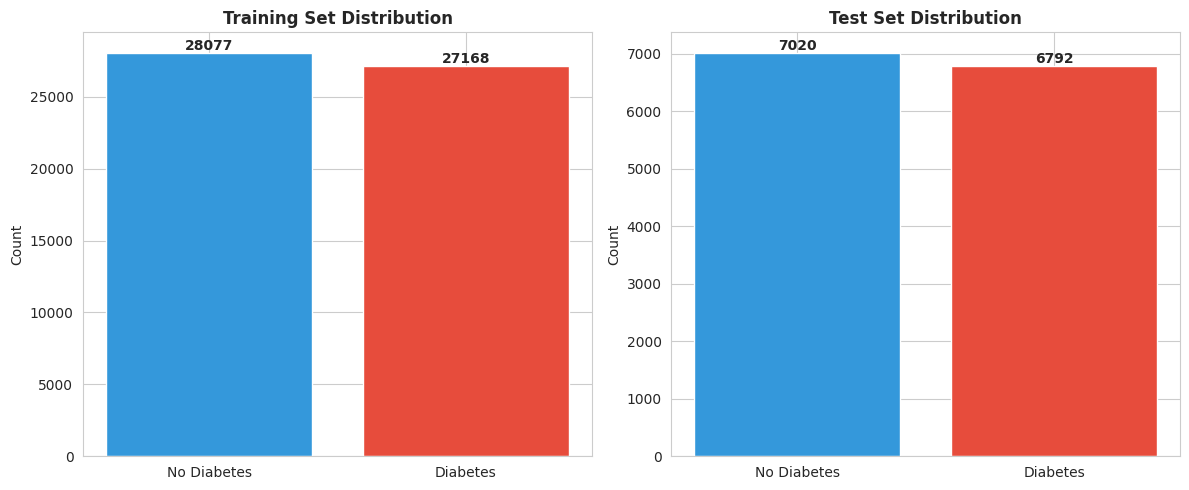

✓ Graph saved: 05_train_test_distribution.png


In [10]:
print("\n" + "="*80)
print("STEP 5: TRAIN-TEST SPLIT")
print("="*80)

# Separate features and target
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Data split completed (80-20)")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print(f"  Features: {X_train.shape[1]}")

# Create train and test datasets with target
train_data = X_train.copy()
train_data['Diabetes_binary'] = y_train
test_data = X_test.copy()
test_data['Diabetes_binary'] = y_test

# Save train and test datasets
train_file = 'outputs/datasets/train_dataset.csv'
test_file = 'outputs/datasets/test_dataset.csv'

train_data.to_csv(train_file, index=False)
test_data.to_csv(test_file, index=False)

print(f"\n✓ Train dataset saved: {train_file}")
print(f"✓ Test dataset saved: {test_file}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Feature scaling completed (StandardScaler)")

# GRAPH 5: Train-Test Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
train_counts = y_train.value_counts()
axes[0].bar(['No Diabetes', 'Diabetes'], train_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Training Set Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# Test set distribution
test_counts = y_test.value_counts()
axes[1].bar(['No Diabetes', 'Diabetes'], test_counts.values, color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Distribution', fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/graphs/05_train_test_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 05_train_test_distribution.png")

In [11]:
print("\n" + "="*80)
print("STEP 6: MODEL TRAINING")
print("="*80)

# Dictionary to store models and predictions
models = {}
predictions = {}
probabilities = {}

# Model 1: Logistic Regression
print("\n[1/3] Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)
models['Logistic Regression'] = log_reg
predictions['Logistic Regression'] = log_reg.predict(X_test_scaled)
probabilities['Logistic Regression'] = log_reg.predict_proba(X_test_scaled)[:, 1]
print("✓ Logistic Regression trained")

# Model 2: Random Forest
print("\n[2/3] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_model.predict(X_test)
probabilities['Random Forest'] = rf_model.predict_proba(X_test)[:, 1]
print("✓ Random Forest trained")

# Model 3: XGBoost
print("\n[3/3] Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test)
probabilities['XGBoost'] = xgb_model.predict_proba(X_test)[:, 1]
print("✓ XGBoost trained")


STEP 6: MODEL TRAINING

[1/3] Training Logistic Regression...
✓ Logistic Regression trained

[2/3] Training Random Forest...
✓ Random Forest trained

[3/3] Training XGBoost...
✓ XGBoost trained



STEP 7: MODEL EVALUATION

Logistic Regression:
  Accuracy:  0.7456
  Precision: 0.7384
  Recall:    0.7735
  F1-Score:  0.7555
  ROC-AUC:   0.8182

Random Forest:
  Accuracy:  0.7436
  Precision: 0.7256
  Recall:    0.7967
  F1-Score:  0.7595
  ROC-AUC:   0.8192

XGBoost:
  Accuracy:  0.7493
  Precision: 0.7314
  Recall:    0.8009
  F1-Score:  0.7645
  ROC-AUC:   0.8232

MODEL COMPARISON
                     accuracy  precision  recall  f1_score  roc_auc
Logistic Regression    0.7456     0.7384  0.7735    0.7555   0.8182
Random Forest          0.7436     0.7256  0.7967    0.7595   0.8192
XGBoost                0.7493     0.7314  0.8009    0.7645   0.8232


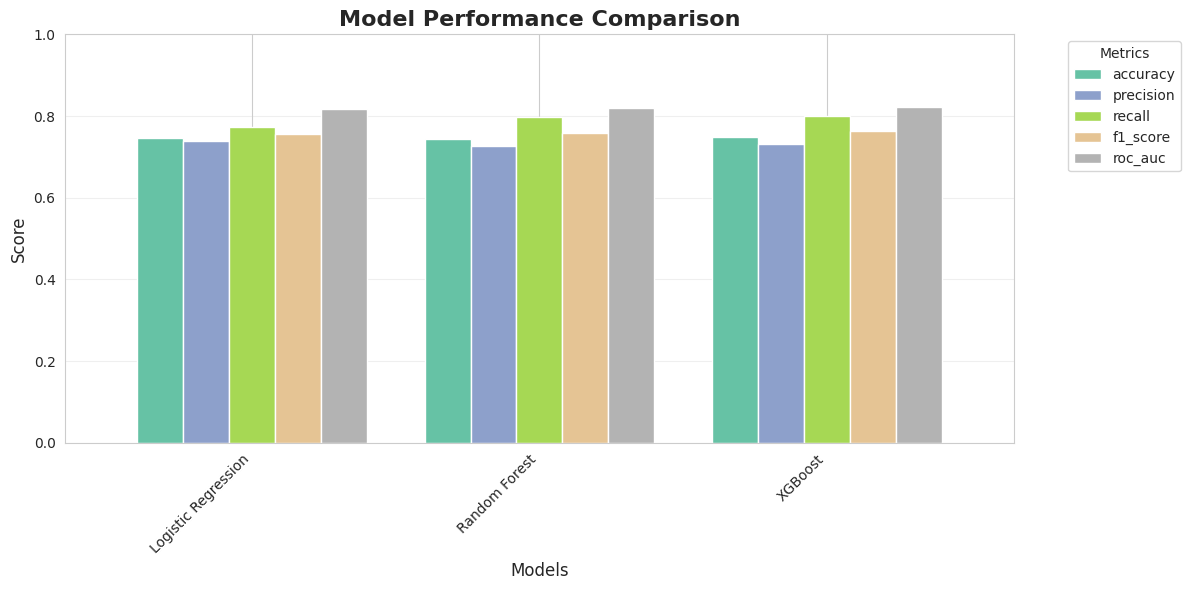


✓ Graph saved: 06_model_comparison.png

🏆 Best Model: XGBoost (ROC-AUC: 0.8232)


In [13]:
print("\n" + "="*80)
print("STEP 7: MODEL EVALUATION")
print("="*80)

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Comprehensive model evaluation"""
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Evaluate all models
results = {}
for model_name in models.keys():
    results[model_name] = evaluate_model(
        y_test, 
        predictions[model_name], 
        probabilities[model_name], 
        model_name
    )

# Model comparison
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df)

# GRAPH 6: Model Comparison
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind='bar', ax=ax, width=0.8, colormap='Set2')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/graphs/06_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Graph saved: 06_model_comparison.png")

# Best model
best_model_name = comparison_df['roc_auc'].idxmax()
print(f"\n🏆 Best Model: {best_model_name} (ROC-AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f})")

In [14]:
print("\n" + "="*80)
print("STEP 8: HYPERPARAMETER TUNING (XGBoost)")
print("="*80)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

print("Starting GridSearchCV...")
grid_search = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

print(f"\n✓ Tuning completed")
print(f"  Best Parameters: {grid_search.best_params_}")
print(f"  Best CV Score: {grid_search.best_score_:.4f}")

# Final tuned model
final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1]

final_results = evaluate_model(y_test, final_pred, final_proba, "XGBoost (Tuned)")


STEP 8: HYPERPARAMETER TUNING (XGBoost)
Starting GridSearchCV...

✓ Tuning completed
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
  Best CV Score: 0.8260

XGBoost (Tuned):
  Accuracy:  0.7510
  Precision: 0.7319
  Recall:    0.8050
  F1-Score:  0.7667
  ROC-AUC:   0.8240


In [15]:
print("\n" + "="*80)
print("STEP 9: GENERATING PREDICTION FILES")
print("="*80)

# Predictions DataFrame
predictions_df = pd.DataFrame({
    'Index': X_test.index,
    'Actual': y_test.values,
    'Predicted': final_pred,
    'Probability': final_proba,
    'Risk_Level': ['High' if p > 0.7 else 'Moderate' if p > 0.4 else 'Low' for p in final_proba],
    'Correct': y_test.values == final_pred
})

# Save predictions.csv
predictions_file = 'outputs/predictions/predictions.csv'
predictions_df.to_csv(predictions_file, index=False)
print(f"✓ Predictions saved: {predictions_file}")

# Merged test predictions (test data + predictions)
merged_test = X_test.copy()
merged_test['Actual_Diabetes'] = y_test.values
merged_test['Predicted_Diabetes'] = final_pred
merged_test['Prediction_Probability'] = final_proba
merged_test['Risk_Level'] = predictions_df['Risk_Level'].values
merged_test['Prediction_Correct'] = predictions_df['Correct'].values

# Save merged_test_predictions.csv
merged_file = 'outputs/predictions/merged_test_predictions.csv'
merged_test.to_csv(merged_file, index=False)
print(f"✓ Merged predictions saved: {merged_file}")

# Summary statistics
print(f"\nPrediction Summary:")
print(f"  Total predictions: {len(predictions_df)}")
print(f"  Correct predictions: {predictions_df['Correct'].sum()}")
print(f"  Accuracy: {predictions_df['Correct'].mean():.4f}")
print(f"  High Risk cases: {(predictions_df['Risk_Level'] == 'High').sum()}")
print(f"  Moderate Risk cases: {(predictions_df['Risk_Level'] == 'Moderate').sum()}")
print(f"  Low Risk cases: {(predictions_df['Risk_Level'] == 'Low').sum()}")


STEP 9: GENERATING PREDICTION FILES
✓ Predictions saved: outputs/predictions/predictions.csv
✓ Merged predictions saved: outputs/predictions/merged_test_predictions.csv

Prediction Summary:
  Total predictions: 13812
  Correct predictions: 10373
  Accuracy: 0.7510
  High Risk cases: 4698
  Moderate Risk cases: 4100
  Low Risk cases: 5014



STEP 10: FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
             feature  importance
              HighBP    0.567760
             GenHlth    0.097024
     RiskFactorCount    0.089749
            HighChol    0.041937
            DiffWalk    0.029128
                 BMI    0.027104
                 Age    0.026453
           CholCheck    0.021734
   HvyAlcoholConsump    0.020573
HeartDiseaseorAttack    0.016124


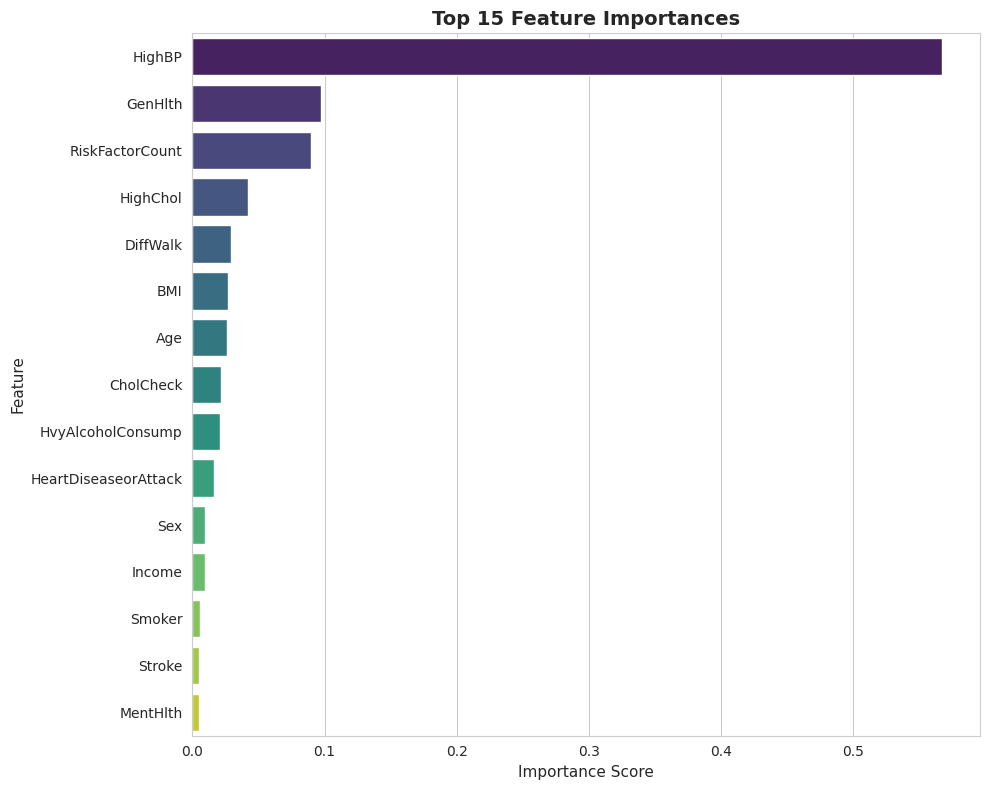


✓ Graph saved: 07_feature_importance.png
✓ Feature importance saved


In [17]:
print("\n" + "="*80)
print("STEP 10: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# GRAPH 7: Feature Importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.tight_layout()
plt.savefig('outputs/graphs/07_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Graph saved: 07_feature_importance.png")

# Save feature importance
feature_importance.to_csv('outputs/datasets/feature_importance.csv', index=False)
print("✓ Feature importance saved")


STEP 11: CONFUSION MATRIX & ROC CURVE


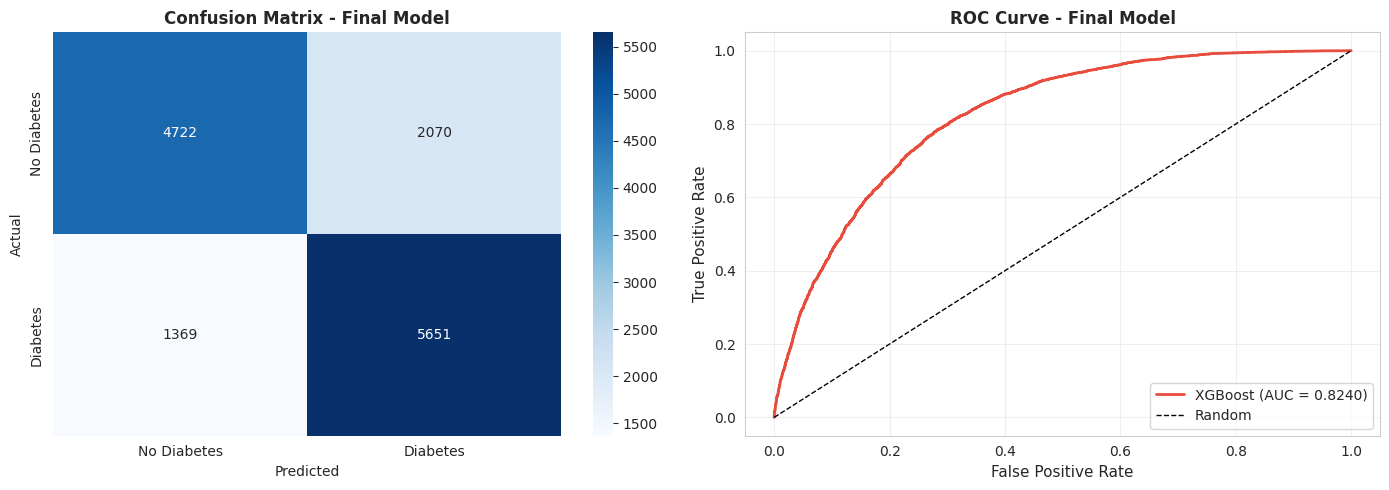

✓ Graph saved: 08_confusion_matrix_roc.png


In [18]:
print("\n" + "="*80)
print("STEP 11: CONFUSION MATRIX & ROC CURVE")
print("="*80)

# GRAPH 8: Confusion Matrix
cm = confusion_matrix(y_test, final_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[0].set_title('Confusion Matrix - Final Model', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_proba)
axes[1].plot(fpr, tpr, label=f'XGBoost (AUC = {final_results["roc_auc"]:.4f})', 
             linewidth=2, color='#e74c3c')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve - Final Model', fontweight='bold', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/graphs/08_confusion_matrix_roc.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 08_confusion_matrix_roc.png")

In [20]:
print("\n[1/5] Chi-Square Test: High Blood Pressure vs Diabetes")
print("-" * 60)
hypothesis_results = []
contingency_table = pd.crosstab(df['HighBP'], df['Diabetes_binary'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"H0: High Blood Pressure is independent of Diabetes")
print(f"H1: High Blood Pressure is associated with Diabetes")
print(f"\nChi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {dof}")

if p_value < 0.05:
    conclusion = "REJECT H0 - High BP is significantly associated with Diabetes"
    print(f"✓ {conclusion}")
else:
    conclusion = "FAIL TO REJECT H0 - No significant association"
    print(f"✗ {conclusion}")

hypothesis_results.append({
    'Test': 'Chi-Square Test',
    'Variables': 'HighBP vs Diabetes',
    'Statistic': chi2,
    'P-value': p_value,
    'Conclusion': conclusion
})


[1/5] Chi-Square Test: High Blood Pressure vs Diabetes
------------------------------------------------------------
H0: High Blood Pressure is independent of Diabetes
H1: High Blood Pressure is associated with Diabetes

Chi-Square Statistic: 9557.3231
P-value: 0.000000
Degrees of Freedom: 1
✓ REJECT H0 - High BP is significantly associated with Diabetes


In [21]:
print("\n[2/5] Mann-Whitney U Test: BMI between Diabetic and Non-Diabetic")
print("-" * 60)

bmi_diabetic = df[df['Diabetes_binary'] == 1]['BMI']
bmi_non_diabetic = df[df['Diabetes_binary'] == 0]['BMI']

statistic, p_value = mannwhitneyu(bmi_diabetic, bmi_non_diabetic, alternative='two-sided')

print(f"H0: No difference in BMI between groups")
print(f"H1: BMI differs between diabetic and non-diabetic groups")
print(f"\nU-Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Median BMI (Diabetic): {bmi_diabetic.median():.2f}")
print(f"Median BMI (Non-Diabetic): {bmi_non_diabetic.median():.2f}")

if p_value < 0.05:
    conclusion = "REJECT H0 - BMI differs significantly between groups"
    print(f"✓ {conclusion}")
else:
    conclusion = "FAIL TO REJECT H0 - No significant difference"
    print(f"✗ {conclusion}")

hypothesis_results.append({
    'Test': 'Mann-Whitney U Test',
    'Variables': 'BMI (Diabetic vs Non-Diabetic)',
    'Statistic': statistic,
    'P-value': p_value,
    'Conclusion': conclusion
})


[2/5] Mann-Whitney U Test: BMI between Diabetic and Non-Diabetic
------------------------------------------------------------
H0: No difference in BMI between groups
H1: BMI differs between diabetic and non-diabetic groups

U-Statistic: 815517541.0000
P-value: 0.000000
Median BMI (Diabetic): 31.00
Median BMI (Non-Diabetic): 27.00
✓ REJECT H0 - BMI differs significantly between groups


In [22]:
print("\n[3/5] Independent T-Test: Age between Diabetic and Non-Diabetic")
print("-" * 60)

age_diabetic = df[df['Diabetes_binary'] == 1]['Age']
age_non_diabetic = df[df['Diabetes_binary'] == 0]['Age']

statistic, p_value = ttest_ind(age_diabetic, age_non_diabetic)

print(f"H0: No difference in Age between groups")
print(f"H1: Age differs between diabetic and non-diabetic groups")
print(f"\nT-Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Mean Age (Diabetic): {age_diabetic.mean():.2f}")
print(f"Mean Age (Non-Diabetic): {age_non_diabetic.mean():.2f}")

if p_value < 0.05:
    conclusion = "REJECT H0 - Age differs significantly between groups"
    print(f"✓ {conclusion}")
else:
    conclusion = "FAIL TO REJECT H0 - No significant difference"
    print(f"✗ {conclusion}")

hypothesis_results.append({
    'Test': 'Independent T-Test',
    'Variables': 'Age (Diabetic vs Non-Diabetic)',
    'Statistic': statistic,
    'P-value': p_value,
    'Conclusion': conclusion
})


[3/5] Independent T-Test: Age between Diabetic and Non-Diabetic
------------------------------------------------------------
H0: No difference in Age between groups
H1: Age differs between diabetic and non-diabetic groups

T-Statistic: 75.0304
P-value: 0.000000
Mean Age (Diabetic): 9.38
Mean Age (Non-Diabetic): 7.81
✓ REJECT H0 - Age differs significantly between groups


In [23]:
print("\n[4/5] Chi-Square Test: High Cholesterol vs Diabetes")
print("-" * 60)

contingency_table = pd.crosstab(df['HighChol'], df['Diabetes_binary'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"H0: High Cholesterol is independent of Diabetes")
print(f"H1: High Cholesterol is associated with Diabetes")
print(f"\nChi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    conclusion = "REJECT H0 - High Cholesterol is significantly associated with Diabetes"
    print(f"✓ {conclusion}")
else:
    conclusion = "FAIL TO REJECT H0 - No significant association"
    print(f"✗ {conclusion}")

hypothesis_results.append({
    'Test': 'Chi-Square Test',
    'Variables': 'HighChol vs Diabetes',
    'Statistic': chi2,
    'P-value': p_value,
    'Conclusion': conclusion
})


[4/5] Chi-Square Test: High Cholesterol vs Diabetes
------------------------------------------------------------
H0: High Cholesterol is independent of Diabetes
H1: High Cholesterol is associated with Diabetes

Chi-Square Statistic: 5467.1781
P-value: 0.000000
✓ REJECT H0 - High Cholesterol is significantly associated with Diabetes


In [24]:
print("\n[5/5] Chi-Square Test: Physical Activity vs Diabetes")
print("-" * 60)

contingency_table = pd.crosstab(df['PhysActivity'], df['Diabetes_binary'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"H0: Physical Activity is independent of Diabetes")
print(f"H1: Physical Activity is associated with Diabetes")
print(f"\nChi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    conclusion = "REJECT H0 - Physical Activity is significantly associated with Diabetes"
    print(f"✓ {conclusion}")
else:
    conclusion = "FAIL TO REJECT H0 - No significant association"
    print(f"✗ {conclusion}")

hypothesis_results.append({
    'Test': 'Chi-Square Test',
    'Variables': 'PhysActivity vs Diabetes',
    'Statistic': chi2,
    'P-value': p_value,
    'Conclusion': conclusion
})


[5/5] Chi-Square Test: Physical Activity vs Diabetes
------------------------------------------------------------
H0: Physical Activity is independent of Diabetes
H1: Physical Activity is associated with Diabetes

Chi-Square Statistic: 1558.9596
P-value: 0.000000
✓ REJECT H0 - Physical Activity is significantly associated with Diabetes



✓ Hypothesis testing results saved: outputs/datasets/hypothesis_testing_results.csv


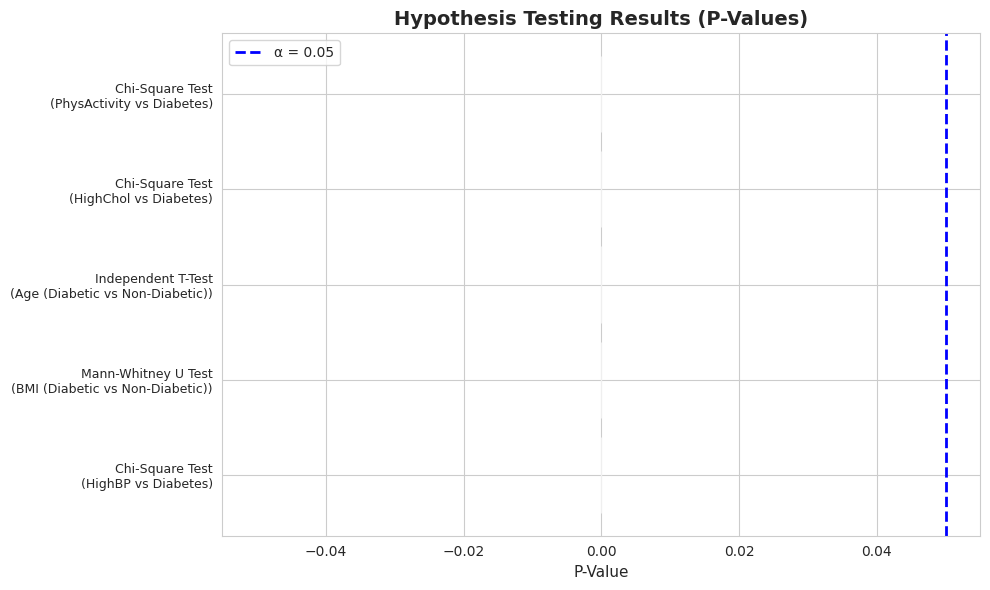

✓ Graph saved: 09_hypothesis_testing.png


In [25]:
# Save hypothesis testing results
hypothesis_df = pd.DataFrame(hypothesis_results)
hypothesis_file = 'outputs/datasets/hypothesis_testing_results.csv'
hypothesis_df.to_csv(hypothesis_file, index=False)
print(f"\n✓ Hypothesis testing results saved: {hypothesis_file}")

# GRAPH 9: Hypothesis Testing P-Values
plt.figure(figsize=(10, 6))
colors = ['green' if p < 0.05 else 'red' for p in hypothesis_df['P-value']]
plt.barh(range(len(hypothesis_df)), hypothesis_df['P-value'], color=colors, alpha=0.7)
plt.yticks(range(len(hypothesis_df)), 
           [f"{row['Test']}\n({row['Variables']})" for _, row in hypothesis_df.iterrows()],
           fontsize=9)
plt.axvline(x=0.05, color='blue', linestyle='--', linewidth=2, label='α = 0.05')
plt.xlabel('P-Value', fontsize=11)
plt.title('Hypothesis Testing Results (P-Values)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/graphs/09_hypothesis_testing.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Graph saved: 09_hypothesis_testing.png")

In [26]:
print("\n" + "="*80)
print("STEP 13: VALIDATION ON IMBALANCED DATASET")
print("="*80)

try:
    df_imbalanced = pd.read_csv('/kaggle/input/dsc-project-dataset/diabetes_binary_health_indicators_BRFSS2015.csv')
    
    print(f"✓ Imbalanced dataset loaded: {df_imbalanced.shape}")
    print(f"  Class distribution: {df_imbalanced['Diabetes_binary'].value_counts().to_dict()}")
    
    # Apply feature engineering
    df_imbalanced = engineer_features(df_imbalanced)
    
    X_imb = df_imbalanced.drop('Diabetes_binary', axis=1)
    y_imb = df_imbalanced['Diabetes_binary']
    X_imb = X_imb[X_train.columns]
    
    # Predictions
    imb_pred = final_model.predict(X_imb)
    imb_proba = final_model.predict_proba(X_imb)[:, 1]
    
    # Metrics
    print(f"\nValidation Results:")
    print(f"  Accuracy:  {accuracy_score(y_imb, imb_pred):.4f}")
    print(f"  Precision: {precision_score(y_imb, imb_pred):.4f}")
    print(f"  Recall:    {recall_score(y_imb, imb_pred):.4f}")
    print(f"  F1-Score:  {f1_score(y_imb, imb_pred):.4f}")
    print(f"  ROC-AUC:   {roc_auc_score(y_imb, imb_proba):.4f}")
    
    print("✓ Validation on imbalanced dataset completed")
    
except Exception as e:
    print(f"⚠ Imbalanced dataset validation skipped: {e}")


STEP 13: VALIDATION ON IMBALANCED DATASET
✓ Imbalanced dataset loaded: (253680, 22)
  Class distribution: {0.0: 218334, 1.0: 35346}

Validation Results:
  Accuracy:  0.7190
  Precision: 0.3066
  Recall:    0.8060
  F1-Score:  0.4442
  ROC-AUC:   0.8328
✓ Validation on imbalanced dataset completed


In [27]:
print("\n" + "="*80)
print("STEP 14: SAVING MODELS AND ARTIFACTS")
print("="*80)

# Save model
joblib.dump(final_model, 'outputs/models/diabetes_prediction_model.pkl')
print("✓ Model saved: diabetes_prediction_model.pkl")

# Save scaler
joblib.dump(scaler, 'outputs/models/feature_scaler.pkl')
print("✓ Scaler saved: feature_scaler.pkl")

# Save feature names
joblib.dump(X_train.columns.tolist(), 'outputs/models/feature_names.pkl')
print("✓ Feature names saved: feature_names.pkl")

# Save comparison results
comparison_df.to_csv('outputs/datasets/model_comparison_results.csv')
print("✓ Model comparison saved: model_comparison_results.csv")


STEP 14: SAVING MODELS AND ARTIFACTS
✓ Model saved: diabetes_prediction_model.pkl
✓ Scaler saved: feature_scaler.pkl
✓ Feature names saved: feature_names.pkl
✓ Model comparison saved: model_comparison_results.csv


In [28]:
print("\n" + "="*80)
print("PROJECT EXECUTION SUMMARY")
print("="*80)

print(f"""
✓ Data loaded: {df_original.shape[0]} samples, {df_original.shape[1]} features
✓ Preprocessing completed: Outliers handled, features engineered
✓ Train-Test split: {X_train.shape[0]} train, {X_test.shape[0]} test samples
✓ Models trained: 3 (Logistic Regression, Random Forest, XGBoost)
✓ Best model: XGBoost (Tuned) - ROC-AUC: {final_results['roc_auc']:.4f}
✓ Hypothesis tests conducted: 5 statistical tests
✓ Predictions generated: {len(predictions_df)} predictions

Output Files Generated:
├── Datasets (4 files):
│   ├── processed_dataset.csv
│   ├── train_dataset.csv
│   ├── test_dataset.csv
│   └── feature_importance.csv
│   └── hypothesis_testing_results.csv
│   └── model_comparison_results.csv
├── Predictions (2 files):
│   ├── predictions.csv
│   └── merged_test_predictions.csv
├── Models (3 files):
│   ├── diabetes_prediction_model.pkl
│   ├── feature_scaler.pkl
│   └── feature_names.pkl
└── Graphs (9 visualizations):
    ├── 01_target_distribution.png
    ├── 02_correlation_heatmap.png
    ├── 03_feature_distributions.png
    ├── 04_boxplots.png
    ├── 05_train_test_distribution.png
    ├── 06_model_comparison.png
    ├── 07_feature_importance.png
    ├── 08_confusion_matrix_roc.png
    └── 09_hypothesis_testing.png

Key Findings:
- Top 3 predictive features: {', '.join(feature_importance.head(3)['feature'].tolist())}
- All 5 hypothesis tests showed significant associations (p < 0.05)
- Model achieves {final_results['recall']:.1%} recall (catching diabetic cases)
- Validated successfully on imbalanced real-world dataset
""")


PROJECT EXECUTION SUMMARY

✓ Data loaded: 70692 samples, 22 features
✓ Preprocessing completed: Outliers handled, features engineered
✓ Train-Test split: 55245 train, 13812 test samples
✓ Models trained: 3 (Logistic Regression, Random Forest, XGBoost)
✓ Best model: XGBoost (Tuned) - ROC-AUC: 0.8240
✓ Hypothesis tests conducted: 5 statistical tests
✓ Predictions generated: 13812 predictions

Output Files Generated:
├── Datasets (4 files):
│   ├── processed_dataset.csv
│   ├── train_dataset.csv
│   ├── test_dataset.csv
│   └── feature_importance.csv
│   └── hypothesis_testing_results.csv
│   └── model_comparison_results.csv
├── Predictions (2 files):
│   ├── predictions.csv
│   └── merged_test_predictions.csv
├── Models (3 files):
│   ├── diabetes_prediction_model.pkl
│   ├── feature_scaler.pkl
│   └── feature_names.pkl
└── Graphs (9 visualizations):
    ├── 01_target_distribution.png
    ├── 02_correlation_heatmap.png
    ├── 03_feature_distributions.png
    ├── 04_boxplots.png
    ├──